**Khoa học dữ liệu**  
Học kì I, 2020 - 2021

<hr>

<br>
<center><b><font size="10">ĐỒ ÁN CUỐI KÌ</font></b></center>
<br>

---

<center><b><font size="6">Dự đoán giá cổ phiếu</font></b></center>

<center><b>Nhóm thực hiện:</b><br>Trần Minh Trí - 1712834<br>Nguyễn Nhật Trường - 1712852</center>

* Dự đoán giá cổ phiếu dựa theo pattern giá trong quá khứ.
* Trả lời được câu hỏi trên sẽ giúp người chơi cổ phiếu quyết định mua hay bán một loại cổ phiếu nào đó.

<hr>

#### Các thư viện hỗ trợ

In [1]:
import datetime
from datetime import date
import pandas as pd

import urllib.robotparser
from selenium import webdriver
from selenium.webdriver.common.by import By
from requests_html import HTML
import time

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import statsmodels.api as sm
import os.path
import numpy as np
import math

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import keras.backend as backend
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split
from keras import callbacks
import pickle

from sklearn import set_config
set_config(display='diagram')
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import gc

from IPython.display import display, HTML, clear_output

# 1. Thu thập dữ liệu

**Nguồn dữ liệu**: Trang web [CafeF](https://s.cafef.vn/) là nguồn sử dụng để thu thập dữ liệu. Từng loại cổ phiếu được sử dụng sẽ được thu thập thông qua trang tìm kiếm của cổ phiếu đó, cụ thể: [BHV](https://s.cafef.vn/Lich-su-giao-dich-BVH-1.chn?fbclid=IwAR0e98txe3qOw8SP_cTAVxXqeTN2CnuAiOnnLMzUXovyH-zJRZXVNBWU2sg).  
Dữ liệu được thu thập bằng phương thức parse HTML sử dụng `selenium`, đến ngày 17/12/2020.

Dữ liệu đã được kiểm tra có thể thu thập:

In [2]:
rp = urllib.robotparser.RobotFileParser()
rp.set_url('https://s.cafef.vn/robots.txt')
rp.read()
rp.can_fetch('*','https://s.cafef.vn/Lich-su-giao-dich-BVH-1.chn')

True

In [3]:
row_id = []
for i in range(1, 21):
    if i%2: row_id.append(str(i).zfill(2) + '_')
    else: row_id.append(str(i).zfill(2) + '_alt')

def get_stock_data(stock_symbol, output_file):
    url = 'https://s.cafef.vn/Lich-su-giao-dich-' + stock_symbol + '-1.chn'    
    
    file = open(output_file, 'w', encoding='utf-8')
    file.write(f'Date,Open,High,Low,Close\n')

    driver = webdriver.Chrome(executable_path='./chromedriver.exe')
    driver.get(url)
    html = HTML(html=driver.page_source)

    while True:        
        for i in row_id:
            html = HTML(html=driver.page_source)
            row = html.find('tr#ctl00_ContentPlaceHolder1_ctl03_rptData2_ctl' + i + 'itemTR', first=True)
            if row:                
                date = row.find('td.Item_DateItem', first=True).text
                date = pd.to_datetime(date, format='%d/%m/%Y').strftime('%Y-%m-%d')
                
                prices = row.find('td.Item_Price10')
                op, hi, lo, cl = prices[5].text, prices[6].text, prices[7].text, prices[1].text
                file.write(f'{date},{op},{hi},{lo},{cl}\n')

        button = driver.find_elements(By.LINK_TEXT, '>')
        if len(button) > 0:
            button[0].click()
            time.sleep(1)
        else:
            break

    file.close()

In [4]:
if not os.path.isfile('csv/BVH.csv'):
    get_stock_data('BVH', 'csv/BVH.csv')
else:
    print('File', 'csv/BVH.csv', 'existed')

File csv/BVH.csv existed


# 2. Phân tích và tiền xử lí dữ liệu

In [5]:
BVH = pd.read_csv('csv/BVH.csv', parse_dates={'Datetime':['Date']}).iloc[::-1]
BVH.set_index(['Datetime'], inplace = True)
BVH

,Open,High,Low,Close
Datetime,,,,
2009-06-25,46.2,46.2,45.0,46.2
2009-06-26,48.5,48.5,48.0,48.5
2009-06-29,50.5,50.5,50.5,50.5
2009-06-30,53.0,53.0,53.0,53.0
2009-07-01,50.5,51.5,50.5,50.5
...,...,...,...,...
2020-12-10,57.9,58.0,56.5,56.7
2020-12-11,56.7,57.5,56.0,57.5
2020-12-14,58.0,59.4,57.3,58.6


* Có 5 cột:
  * `Date`: ngày.
  * `Open`: giá mở cửa.
  * `High`: giá cao nhất.
  * `Low`: giá thấp nhất.
  * `Close`: giá đóng cửa.

In [6]:
BVH.dtypes

Open     float64
High     float64
Low      float64
Close    float64
dtype: object

* Dữ liệu (chưa tiền xử lý), sau khi đưa cột `Date` thành index, có 2868 dòng và 4 cột, với cả 4 cột đều có kiểu dữ liệu `float`.
* Ở đồ án này chỉ sử dụng cột `Close` cho mô hình hóa và dự đoán.

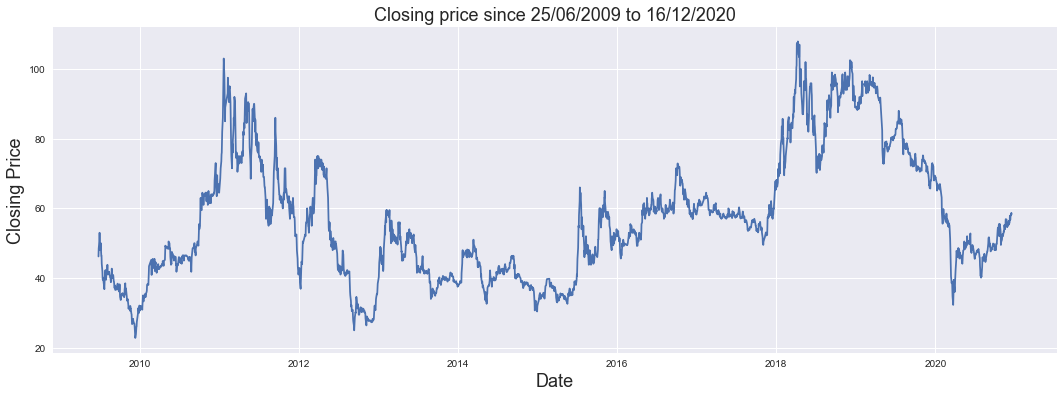

In [7]:
plt.figure(figsize=(18, 6))
plt.title('Closing price since {0} to {1}'.format(BVH.index[0].strftime("%d/%m/%Y"), 
                                                  BVH.index[-1].strftime("%d/%m/%Y")), fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.plot(BVH['Close'])
plt.show()

Phân tích thành phần chuỗi thời gian (**Time-series decomposition**) cho dãy giá đóng. Quá trình này cho phép chuỗi thời gian được thể hiện qua 3 đặc trưng chính là **Trend**, **Seasonality** và **Noise**. Tuy nhiên, do dữ liệu được sử dụng bị thiếu ở một số ngày (vấn đề này sẽ được xử lý ở dưới), chuỗi thời gian được sử dụng không có tần số (*frequency*) cụ thể, dẫn đến quá trình decompose không thể diễn ra.

Để khắc phục vấn đề trên, ta phải tự định nghĩa "chu kỳ" (*period* theo [document](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)) của chuỗi thời gian. Period ở đây được hiểu là số lần *\observation\* (quan sát) trước khi chu trình lặp lại (có nghĩa là sang năm mới: ngày 31/12 trở về 01/01 - lặp lại chu trình). Ví dụ, giả sử dữ liệu thu thập theo từng tháng, tức là dữ liệu được quan sát 12 lần trong 1 năm hay `period = 12`. Ta cũng có thể gọi trường hợp trên là **monthly time series**.

Đối với bài toán hiện tại, giá cổ phiếu được thu thập "hàng ngày" trên trang web, nên ta mong muốn dữ liệu được sử dụng là **daily time series**. Tương ứng, ta đặt `period = 365`.

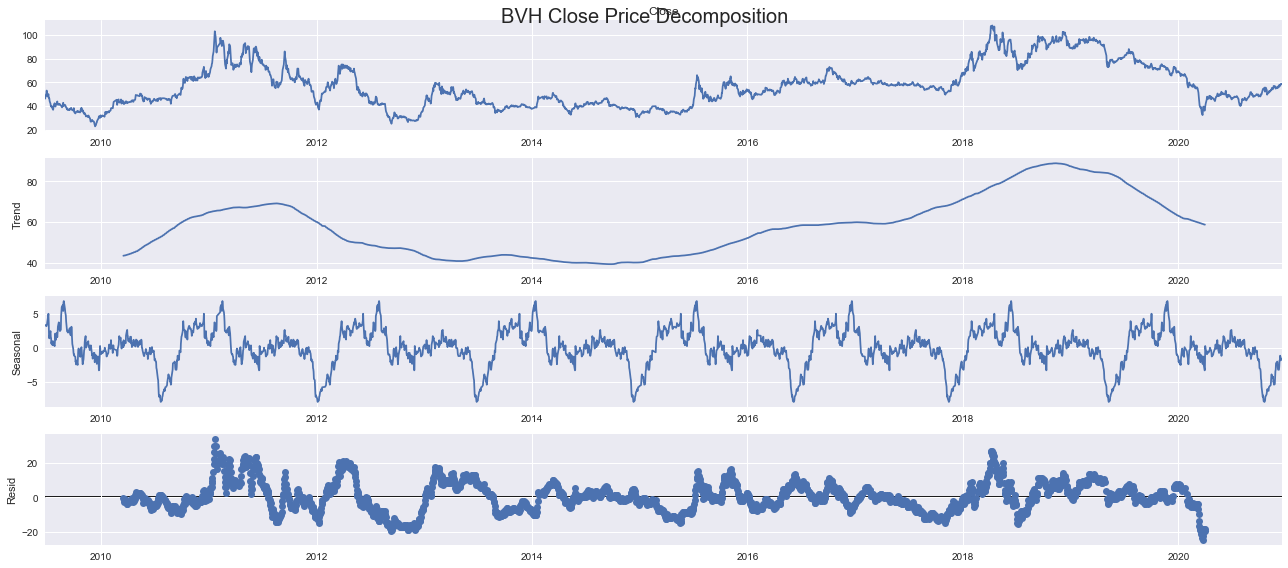

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(BVH['Close'], model = 'additive', period=365)
fig = decomposition.plot()
fig.suptitle('BVH Close Price Decomposition', fontsize=20)
plt.show()

Ta có nhận xét: chuỗi thời gian không có xu hướng - **trend** nào rõ rệt nhưng tính **seasonality** cho biết dữ liệu có diễn biến lặp lại mỗi ~18 tháng. Tuy nhiên, phần **noise** (residue) cho thấy dữ liệu vẫn mang tính ngẫu nhiên cao.

## Tiền xử lí dữ liệu

**Vấn đề sau khi thu thập**: Dữ liệu thu thập được là các dòng theo từng ngày, tuy nhiên, có một số ngày bị thiếu do website không cập nhật giá cổ phiếu vào các ngày đó. Ta cần phải tiền xử lý dữ liệu để "fill" các giá trị còn thiếu ở các ngày đó.

Thêm những điểm dữ liệu thiếu bằng đoạn giữa với 2 đầu là 2 điểm quan sát được. (VD: [1, nan, nan, 7] -> [1, 3, 5, 7])

In [9]:
def fill_time_point(dataframe):
    df = dataframe.copy()
    
    i = 0
    curr = df.index[0]
    end = df.index[-1]

    while curr != end:
        curr += datetime.timedelta(days=1)
        i+=1
        if curr != df.index[i]:
            before = df.iloc[i-1].to_numpy().copy()
            after = df.iloc[i].to_numpy().copy()
            days_missed = (df.index[i] - curr).days
            avg = ((after - before)/(days_missed+1)).round(1)

            while curr != df.index[i]:
                before += avg
                fix = pd.DataFrame({'Open': before[0], 'High': before[1], 'Low': before[2], 'Close': before[3]}, index=[curr])
                df = df.append(fix)
                #print(fix)
                curr += datetime.timedelta(days=1)

    df.sort_index(inplace=True)
    return df

In [10]:
BVH_filled = fill_time_point(BVH)
BVH.shape, BVH_filled.shape

((2868, 4), (4193, 4))

Sau khi tiền xử lý, dữ liệu mới gồm có 4193 dòng và 4 cột:

In [11]:
BVH_filled

,Open,High,Low,Close
2009-06-25,46.2,46.2,45.0,46.2
2009-06-26,48.5,48.5,48.0,48.5
2009-06-27,49.2,49.2,48.8,49.2
2009-06-28,49.9,49.9,49.6,49.9
2009-06-29,50.5,50.5,50.5,50.5
...,...,...,...,...
2020-12-12,57.1,58.1,56.4,57.9
2020-12-13,57.5,58.7,56.8,58.3
2020-12-14,58.0,59.4,57.3,58.6
2020-12-15,58.6,59.4,58.0,58.2


Biểu đồ thể hiện những điểm được điền:

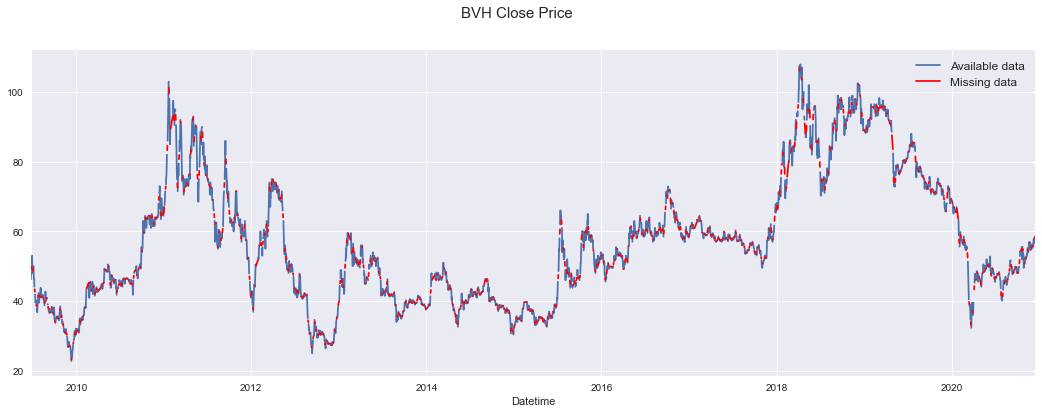

In [12]:
from datetime import date, timedelta
available = BVH.index
date_set = set(available[0] + timedelta(x) for x in range((available[-1] - available[0]).days))
missing = sorted(date_set - set(available))

available_df = BVH.reindex(date_set).sort_index()
missing_df = BVH_filled.loc[missing].reindex(date_set).sort_index()

fig, axes = plt.subplots(figsize=(18, 6))

ax1 = available_df['Close'].plot(label='Available data')
ax1.legend(fontsize=12)

ax2 = missing_df['Close'].plot(color='red', label='Missing data')
ax2.legend(fontsize=12)

fig.suptitle('BVH Close Price', fontsize=15)
plt.show()

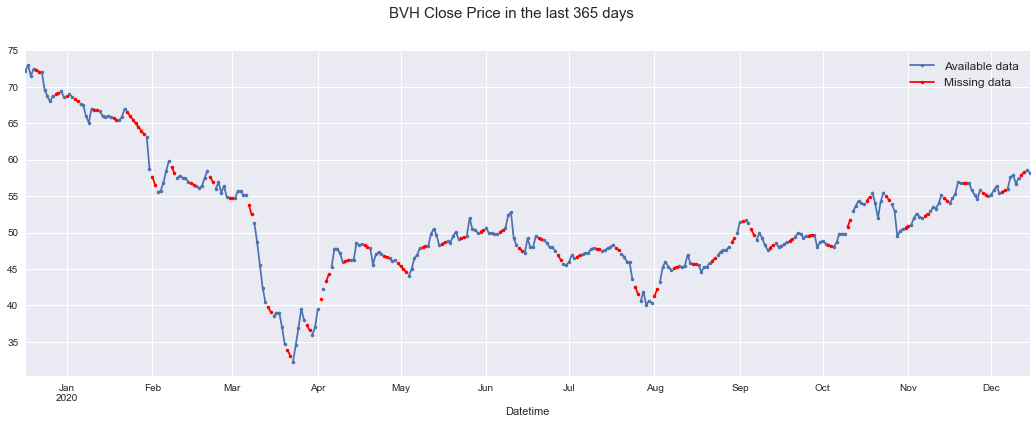

In [13]:
fig, axes = plt.subplots(figsize=(18, 6))

ax1 = available_df['Close'][-365:].plot(marker='.', label='Available data')
ax1.legend(fontsize=12)

ax2 = missing_df['Close'][-365:].plot(color='red', marker='.', label='Missing data')
ax2.legend(fontsize=12)

fig.suptitle('BVH Close Price in the last 365 days', fontsize=15)
plt.show()

Mô hình dự đoán giá đóng cửa trong ngày, cần tách riêng ra

In [14]:
def get_close_price(df):
    return df['Close'].values[:, np.newaxis] # reshape cho input của scaler

### Tách dữ liệu

Dữ liệu ban đầu được chia thành 3 tập: train, validation, test với tỉ lệ (gần đúng) 70% - 15% - 15%.

In [15]:
# Split train - validation - test
#        70%        15%       15%
def split_data(dataset):
    train_data, test_data = train_test_split(dataset, shuffle=False, test_size=0.15)
    train_data, validation_data = train_test_split(train_data, shuffle=False, test_size=0.177)
    
    return train_data, validation_data, test_data

### Chuẩn hóa dữ liệu

Nhóm sử dụng MinMaxScaler để chuẩn hóa dữ liệu về `range(0, 1)`.

### Chuyển dữ liệu về các timestep sequences

* Tập X (input) chứa dữ liệu giá đóng cửa *step* ngày trước ngày *n* cần dự đoán.
* Tập Y (output) chứa dữ liệu giá đóng cửa 1 ngày *n* cần dự đoán.

In [16]:
class Timestep_Converter(BaseEstimator, TransformerMixin):
    def __init__(self, steps=50, lag=0):
        self.steps = steps
        self.lag = lag
    def fit(self, X_df, y=None):
        return self
    def transform(self, data, y=None):
            X = []
            Y = []

            for i in range(len(data)):
                end_ixd = i + self.steps

                if end_ixd > len(data)-1:
                    break

                seq_x, seq_y = data[i:end_ixd-self.lag], data[end_ixd]
                X.append(np.array(seq_x))
                Y.append(seq_y)

            X = np.array(X).reshape(len(X), self.steps-self.lag, 1)
            Y = np.array(Y)

            return X,Y

# 3. Mô hình hóa

## 3.1. Tạo pipeline tiền xử lí

In [17]:
preprocess_pipeline = make_pipeline(FunctionTransformer(fill_time_point),
                                    FunctionTransformer(get_close_price),
                                    MinMaxScaler(feature_range=(0,1)),
                                    Timestep_Converter())

preprocess_pipeline

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function fill_time_point at 0x000001DAE81DB1F0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function get_close_price at 0x000001DAEAC6C550>)),
                ('minmaxscaler', MinMaxScaler()),
                ('timestep_converter', Timestep_Converter())])

## 3.2. Xây dựng mô hình

Nhóm sử dụng **mô hình LSTM** của thư viện `keras`:

In [18]:
def create_LSTM(input_shape, lr):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.25))
    model.add(Dense(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')
    return model

In [19]:
class Timeseries_Model:
    def __init__(self, steps=50, lr=0.001, batch_size=1, patience=15, preprocess_pipeline=None):
        self.steps = steps
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.preprocess_pipeline = preprocess_pipeline
        if preprocess_pipeline is not None:
            self.preprocess_pipeline.set_params(timestep_converter__steps = self.steps)
        
    def set_params(self, **kwargs):
        self.steps = kwargs.get('steps', self.steps)
        self.preprocess_pipeline.set_params(timestep_converter__steps = self.steps)
        self.lr = kwargs.get('lr', self.lr)
        self.batch_size = kwargs.get('batch_size', self.batch_size)
        self.patience = kwargs.get('patience', self.patience)
        
    def build_model(self):
        self.model = create_LSTM((self.steps,1), self.lr)

    def fit(self, train_data, validation_data=None):
        X_train, Y_train = self.preprocess_pipeline.fit_transform(train_data)
        if validation_data is not None:
            X_val, Y_val = self.preprocess_pipeline.transform(validation_data)
        
            earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", 
                                                    patience = self.patience, 
                                                    restore_best_weights = True, verbose=2)
        
            return self.model.fit(X_train, Y_train, validation_data=(X_val, Y_val), 
                            batch_size=self.batch_size, verbose=0, epochs=100, 
                                  callbacks=[earlystopping])
        else:
            earlystopping = callbacks.EarlyStopping(monitor ="loss", mode ="min", 
                                                    patience = self.patience, 
                                                    restore_best_weights = True, verbose=2)
            return self.model.fit(X_train, Y_train, 
                            batch_size=self.batch_size, verbose=0, epochs=100, 
                                  callbacks=[earlystopping])
    
    def predict(self, data, return_y = False):
        X, Y = self.preprocess_pipeline.transform(data)
        scaler = self.preprocess_pipeline['minmaxscaler']

        if return_y:
            return scaler.inverse_transform(Y), scaler.inverse_transform(self.model.predict(X))
        return scaler.inverse_transform(self.model.predict(X))
    
    def error(self, data):
        X, Y = self.preprocess_pipeline.transform(data)
        scaler = self.preprocess_pipeline['minmaxscaler']
        
        Y_pred = scaler.inverse_transform(self.model.predict(X))
        Y_ = scaler.inverse_transform(Y)

        return np.mean( (Y_pred-Y_)**2 )
    
    def save(self, file):
        self.model.save(file)
        
    def load(self, file):
        if not os.path.exists(to_save):
            print("File", file, "doesnt exist")
            return
        self.model = load_model(file)
        
    def get_scaler(self):
        return self.preprocess_pipeline['minmaxscaler']
    
    def predict_ahead(self, data, number_of_date):
        X, Y = self.preprocess_pipeline.transform(data)
        scaler = self.preprocess_pipeline['minmaxscaler']
        
        last_X = X[-1][:,0]
        prediction = np.array([])

        for i in range(number_of_date):
            next_Y = self.model.predict(last_X.reshape(1, len(last_X), 1))
            prediction = np.append(prediction, next_Y[0][0])
            last_X = np.append(last_X[1:], next_Y)

        prediction = scaler.inverse_transform(prediction.reshape(-1, 1))

        idx = pd.date_range(data.index[-1], periods=number_of_date+1, freq='1d')[1:]
        return pd.Series(prediction[:,0], index=idx)

## 3.3. Tìm mô hình tốt nhất

Nhóm thử nghiệm các tham số `step`, `learning rate` và `batch_size`:

In [20]:
train_data, validation_data, test_data = split_data(BVH)
preprocess_pipeline.fit(train_data)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function fill_time_point at 0x000001DAE81DB1F0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function get_close_price at 0x000001DAEAC6C550>)),
                ('minmaxscaler', MinMaxScaler()),
                ('timestep_converter', Timestep_Converter())])

In [21]:
# Warning: Lâu
total_t = time.time()
list_steps=[30, 40, 50, 60]
list_lr=[0.001, 0.01, 0.1, 1]
list_batch_size=[16, 32, 64, 128]

val_errs = dict()
best_val_err = 999999
best_steps, best_lr, best_batch_size = 0,0,0

for steps in list_steps:

    val_err = []
    for lr in list_lr:
        err = []
        
        for batch_size in list_batch_size:
            model = Timeseries_Model(steps = steps, lr = lr, batch_size = batch_size, 
                                     preprocess_pipeline=preprocess_pipeline)
            
            to_save = "models/LLDrDD_lr={0}_step={1}_batchsize={2}".format(lr, steps, batch_size)
            starttime = time.time()
            print("<<<< Started", to_save, "at", 
                  time.strftime('%H:%M:%S', time.localtime(starttime)), '>>>>')
        
            if not os.path.exists(to_save):
                print('     Building model')
                model.build_model()
                history = model.fit(train_data, validation_data)
                model.save(to_save)
            else:
                print('     Loading model')
                model.load(to_save)
            
            mse = model.error(validation_data)
            print("<<<< Finished. Time elapsed:", time.time() - starttime,'>>>>\n')
            
            if mse < best_val_err:
                best_val_err = mse
                best_steps, best_lr, best_batch_size = steps, lr, batch_size
                
            err.append(round(mse, 3))
            
            # Free memory            
            del model
            backend.clear_session() 
            gc.collect()
            clear_output(wait=True)
            
            
        val_err.append(err)

    val_errs[steps] = pd.DataFrame(val_err,columns=list_batch_size,index=list_lr)

print("Finished! Total time elapsed:", (time.time() - total_t)/60, 'm')

Finished! Total time elapsed: 24.65478660662969 m


Kết quả các model

In [22]:
for k in val_errs.keys():
    display(val_errs[k])
    print("Steps =", k, end='')

,16,32,64,128
0.001,2.641,2.709,2.667,5.385
0.010,2.694,2.826,2.540,2.720
0.100,12.374,158.620,518.279,656.935
1.000,275.121,531.982,265.790,265.830


Steps = 30

,16,32,64,128
0.001,2.654,2.756,2.693,2.754
0.010,2.981,2.758,2.615,2.779
0.100,307.204,9.640,201.830,17.179
1.000,351.861,420.479,506.187,331.855


Steps = 40

,16,32,64,128
0.001,2.753,2.768,2.691,2.888
0.010,3.006,2.831,2.691,2.767
0.100,3.229,251.058,7.634,250.738
1.000,315.933,252.218,273.768,757.582


Steps = 50

,16,32,64,128
0.001,2.901,2.845,2.750,3.474
0.010,2.956,2.842,2.853,2.738
0.100,575.372,4.530,7.583,260.256
1.000,263.542,240.983,240.733,423.566


Steps = 60

In [23]:
# Save result
pickle.dump(val_errs, open('result.pkl', 'wb'))

Model tốt nhất

In [24]:
best_val_err, best_steps, best_lr, best_batch_size

(2.5402476770064077, 30, 0.01, 64)

In [25]:
best_model = Timeseries_Model(steps = best_steps, lr = best_lr, batch_size = best_batch_size, 
                              preprocess_pipeline=preprocess_pipeline)

best = "models/LLDrDD_lr={0}_step={1}_batchsize={2}".format(best_lr, best_steps, best_batch_size)
best_model.load(best)

### Kết quả model tốt nhất trên tập validation

In [26]:
def plot_model_prediction(Y, predicted_Y, idx, title='', eval_error=False, zoom_in=[], zoom_title=''):
    valid_vs_prediction = pd.DataFrame({'Actual': Y.reshape(len(Y))}, index=idx)
    valid_vs_prediction['Predicted'] = predicted_Y.reshape(len(predicted_Y))
    valid_vs_prediction['Error'] = valid_vs_prediction['Actual'] - valid_vs_prediction['Predicted']
    
    std_part = 1.96 # Độ tin cậy 95%, [11]
    err_std = valid_vs_prediction['Error'].std(axis=0)
    err_mean = np.absolute(valid_vs_prediction['Error'].mean(axis=0))

    pred_upper = valid_vs_prediction['Predicted'] + err_mean + err_std * std_part
    pred_lower = valid_vs_prediction['Predicted'] - err_mean - err_std * std_part
    
    if eval_error:        
        print('MSE:', np.mean( (valid_vs_prediction['Actual'] - valid_vs_prediction['Predicted'])**2 ))
        print(valid_vs_prediction['Error'].describe())
        plt.figure(figsize=(8,4))
        valid_vs_prediction['Error'].hist(bins=50).set_title('Error distribution')
        plt.show()
        plt.figure(figsize=(8,4))
        valid_vs_prediction['Error'].plot(kind='box', grid=True).set_title("Error")
        plt.show()
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Closing Price', fontsize=18)
    plt.plot(valid_vs_prediction['Actual'], color='b')
    plt.plot(valid_vs_prediction['Predicted'], color='r')
    plt.fill_between(x=valid_vs_prediction.index, y1=pred_upper, y2=pred_lower, 
                     color='green', lw=2, alpha=0.2)
    plt.legend(['Actual', 'Predicted'], loc='lower right')
    plt.show()
    
    if len(zoom_in) > 0:
        plt.figure(figsize=(16,10))
        plt.title(zoom_title)
        plt.plot(valid_vs_prediction['Actual'][zoom_in[0]:zoom_in[1]], 
                 label='Actual', marker='o', color='b')
        plt.plot(valid_vs_prediction['Predicted'][zoom_in[0]:zoom_in[1]], 
                 label='Predicted', marker='o', color='r')
        plt.fill_between(x=valid_vs_prediction.index[zoom_in[0]:zoom_in[1]], 
                         y1=pred_upper[zoom_in[0]:zoom_in[1]], 
                         y2=pred_lower[zoom_in[0]:zoom_in[1]], color='green', lw=2, alpha=0.2)
        plt.legend(loc='lower right')
        plt.show()

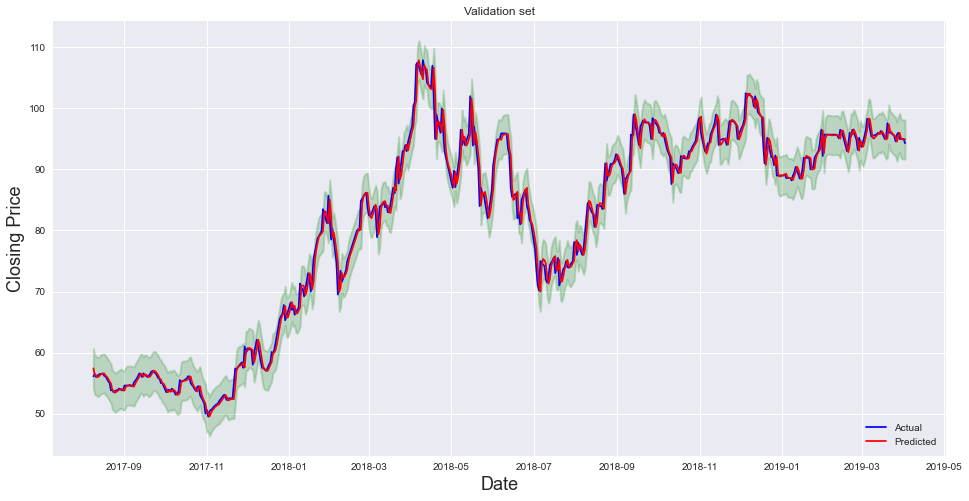

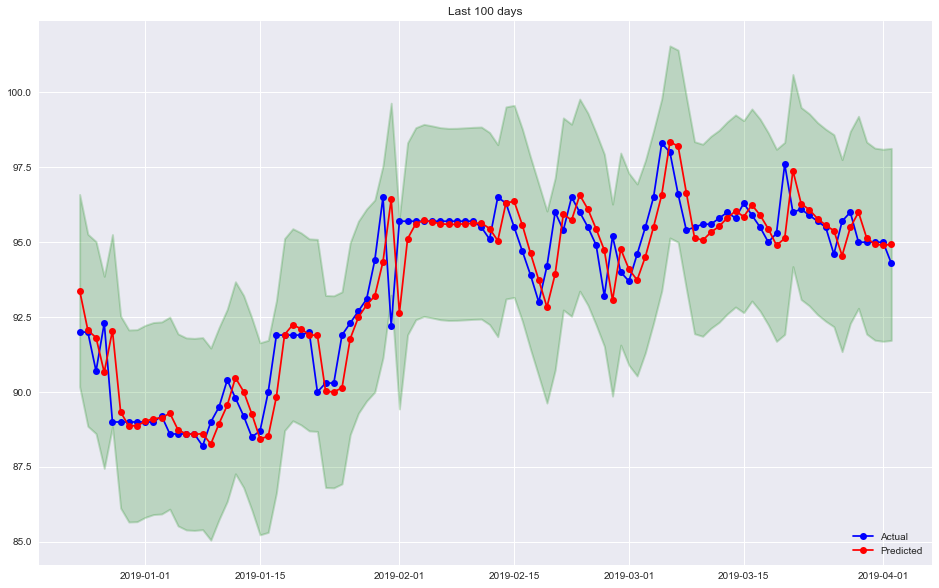

In [27]:
Y_, Y_pred_ = best_model.predict(validation_data, return_y = True)
plot_model_prediction(Y_, Y_pred_, fill_time_point(validation_data).index[best_steps:], 
                      title='Validation set', zoom_in=[-100, None], zoom_title='Last 100 days')

# 3.4. Độ lỗi trên tập test

Huấn luyện model với dữ liệu train và validation

In [28]:
final_model = Timeseries_Model(steps = best_steps, lr = best_lr, batch_size = best_batch_size, 
                              preprocess_pipeline=preprocess_pipeline)
final_model.build_model()
final_model.fit(train_data.append(validation_data))

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping


MSE: 1.3447816836724376
count    594.000000
mean      -0.653280
std        0.958934
min       -6.367963
25%       -1.056481
50%       -0.671018
75%       -0.212715
max        3.781866
Name: Error, dtype: float64


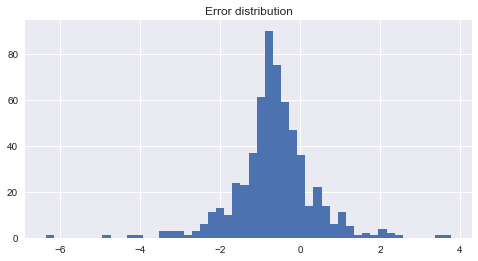

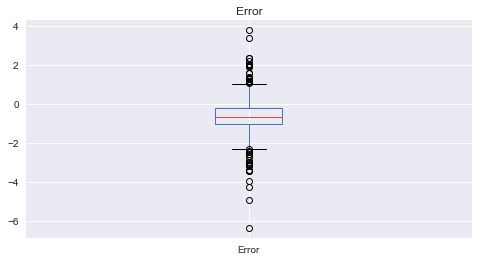

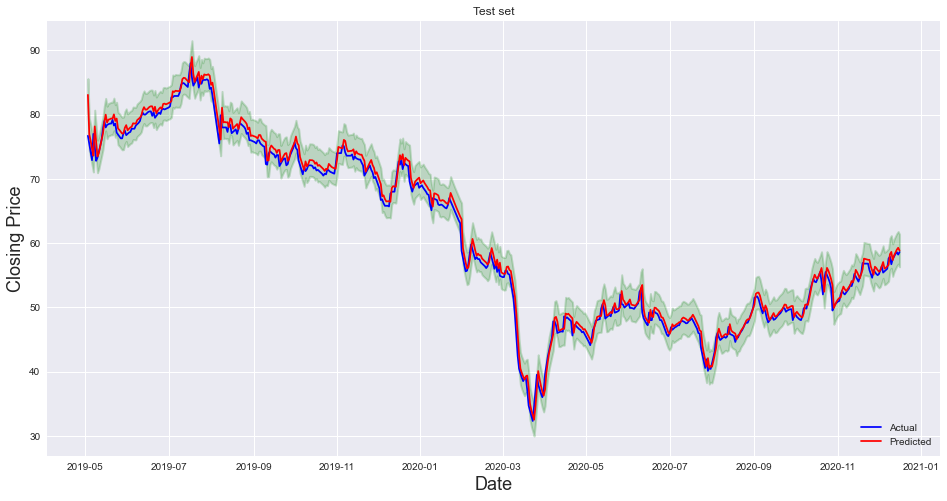

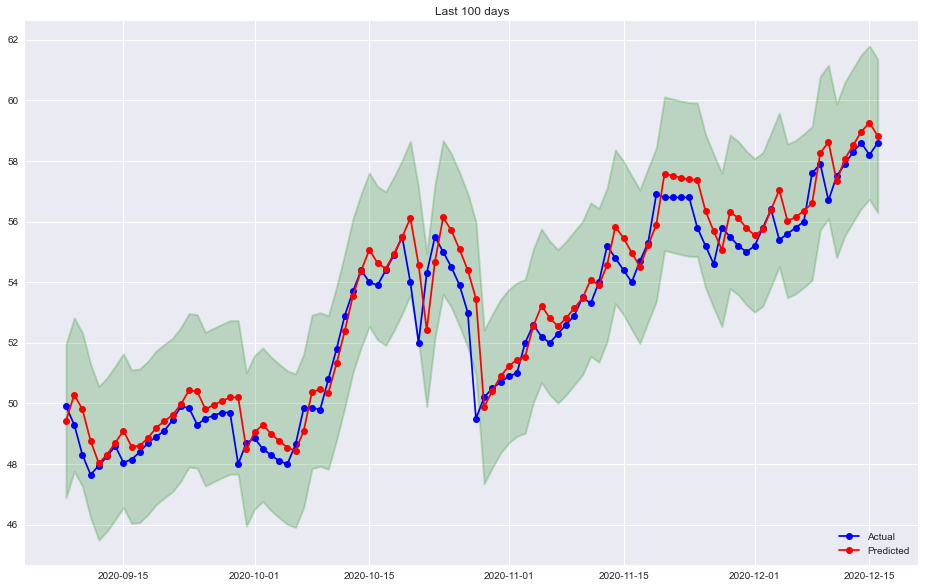

In [29]:
Y_, Y_pred_ = final_model.predict(test_data, return_y = True)
plot_model_prediction(Y_, Y_pred_, fill_time_point(test_data).index[best_steps:], 
                      title='Test set', eval_error=True, 
                      zoom_in=[-100, None], zoom_title='Last 100 days')

# 4. Dự đoán

Nhóm thử dự đoán giá đóng cửa cho 7 ngày tiếp theo, với mỗi ngày dự đoán được thêm vào chuỗi quan sát để dự đoán cho ngày tiếp theo:
* Y(n) = f(O(n-1), O(n-2),...)
* Y(n+1) = f(Y(n), O(n-1), O(n-2),...)

In [30]:
def plot_future_prediction(Y, predicted_Y, idx, next_predict, real_data, title='', show=0):
    valid_vs_prediction = pd.DataFrame({'Actual': Y.reshape(len(Y))}, index=idx)
    valid_vs_prediction['Predicted'] = predicted_Y.reshape(len(predicted_Y))
    valid_vs_prediction['Error'] = valid_vs_prediction['Actual'] - valid_vs_prediction['Predicted']
    
    std_part = 1.96 # Độ tin cậy 95%, [11]
    err_std = valid_vs_prediction['Error'].std(axis=0)
    err_mean = np.absolute(valid_vs_prediction['Error'].mean(axis=0))

    pred_upper = valid_vs_prediction['Predicted'][-show:] + err_mean + err_std * std_part
    pred_lower = valid_vs_prediction['Predicted'][-show:] - err_mean - err_std * std_part
    
#     next_pred_upper, next_pred_lower = [], []
#     for i in range(len(next_predict)):
#         next_pred_upper.append(next_predict[i] + (err_mean + err_std * std_part*(i+1)))
#         next_pred_lower.append(next_predict[i] - (err_mean + err_std * std_part*(i+1)))
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(valid_vs_prediction['Actual'][-show:], marker='o', color='b')
    plt.plot(valid_vs_prediction['Predicted'][-show:], marker='o', color='r')
    plt.plot(next_predict, marker='o', color='r')
    plt.plot(real_data, marker='o', color='navy')
    plt.fill_between(x=valid_vs_prediction.index[-show:], y1=pred_upper, y2=pred_lower, 
                     color='green', lw=2, alpha=0.2)
#     plt.fill_between(x=next_predict.index, y1=next_pred_upper, y2=next_pred_lower, 
#                      color='green', lw=2, alpha=0.2)
    plt.legend(['Actual', 'Prediction'], 
               loc='lower right')
    plt.show()

In [31]:
read_data = pd.read_csv('csv/BVH_next7.csv', parse_dates={'Datetime':['Date']}).iloc[::-1]
read_data.set_index(['Datetime'], inplace = True)
read_data

,Open,High,Low,Close
Datetime,,,,
2020-12-17,58.4,58.6,57.0,57.0
2020-12-18,57.0,57.7,56.6,57.1
2020-12-21,57.6,57.8,56.9,57.1
2020-12-22,57.1,57.4,56.8,56.9
2020-12-23,57.3,60.0,56.9,58.6
2020-12-24,59.0,59.6,57.0,58.4
2020-12-25,58.9,62.4,58.3,61.9


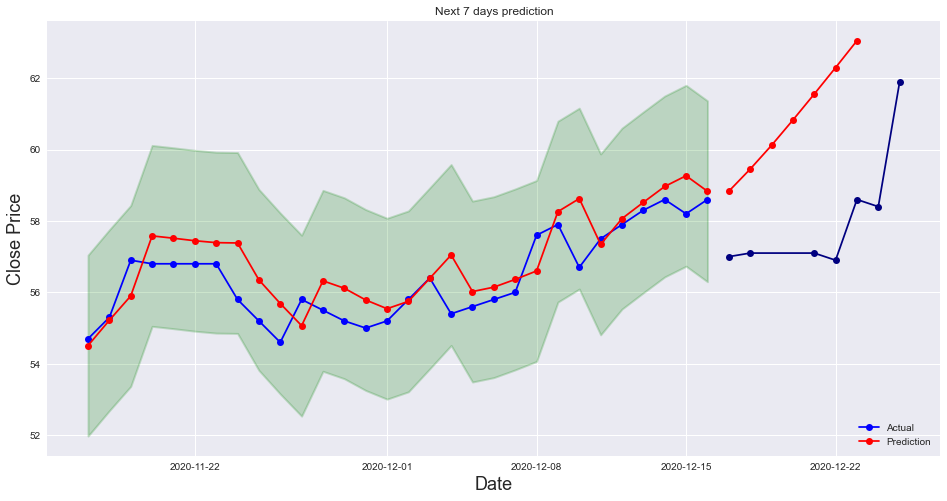

In [32]:
next_predict = final_model.predict_ahead(test_data, number_of_date=7)
Y_, Y_pred_ = final_model.predict(test_data, True)

plot_future_prediction(Y_, Y_pred_, fill_time_point(test_data).index[best_steps:],
                       next_predict, real_data=read_data['Close'], title='Next 7 days prediction', show=30)

# 5. Đánh giá quá trình

### Kinh nghiệm tích lũy

 - Qua đồ án này, nhóm học được nhiều về mô hình hóa dự đoán cho kiểu dữ liệu chuỗi thời gian, kiểu dữ liệu chưa được demo trực tiếp trong khóa học
 - Học và làm quen với sử dụng pipeline cho việc huấn luyện được gọn gàng hơn

### Khó khăn

 - Lần đầu tiếp xúc với việc dự đoán trên kiểu timeseries nên nhóm phải tốn nhiều thời gian nghiên cứu, nhưng thấy được đó vẫn chưa đủ. Tiền xử lý, mô hình hóa còn nhiều chỗ có thể cải tiến để thu được mô hình tốt hơn
 - Cách dự đoán tương lai gần của mô hình có sai số qua các ngày tăng rất cao, hướng tăng trưởng khi đúng, khi sai tùy model. Nhóm xét thấy phần này thực hiện chưa thành công

### Hướng phát triển nếu có thêm thời gian

 - Tìm hiểu thêm các phương pháp tiền xử lí để cải tiến mô hình
 - Tìm hiểu thêm về cách dự đoán tương lai gần khi đã có mô hình máy học
 - Tìm hiểu thêm và chạy thử các siêu tham số trên cái layer 

# 6. Nguồn tham khảo

[1] https://insights.magestore.com/posts/giai-thuat-time-series-forecasting

[2] https://www.datacamp.com/community/tutorials/lstm-python-stock-market

[3] https://randerson112358.medium.com/stock-price-prediction-using-python-machine-learning-e82a039ac2bb

[4] https://viblo.asia/p/lam-quen-voi-keras-gGJ59mxJ5X2

[5] https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

[6] https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

[7] https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

[8] https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

[9] https://viblo.asia/p/optimizer-hieu-sau-ve-cac-thuat-toan-toi-uu-gdsgdadam-Qbq5QQ9E5D8

[10] https://www.phamduytung.com/blog/2018-10-02-understanding-epoch-batchsize-iterations/

[11] https://otexts.com/fpp2/prediction-intervals.html

[12] https://thorpham.github.io/blog/2018/05/25/keras/

[13] https://v8doc.sas.com/sashtml/ets/chap2/sect21.htm#:~:text=How%20often%20the%20observations%20of,called%20a%20monthly%20time%20series.